In [1]:
import numpy as np
import pandas as pd
import math

from scipy.fftpack import fft
from scipy.signal import welch
from detecta import detect_peaks


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter
from imblearn.over_sampling import ADASYN 

from sk_utils import *
from pprint import pprint

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import  GridSearchCV, train_test_split

import pickle


### Load and Input Data

In [2]:
train_ts = pd.read_csv("train_time_series.csv")
train_labels = pd.read_csv("train_labels.csv")

In [3]:
def magnitude(activity):
    '''
    Calculates the magnitude of a 3D vector
    '''
    x_2 = activity['x'] * activity['x']
    y_2 = activity['y'] * activity['y']
    z_2 = activity['z'] * activity['z']
    mag_2 = x_2 + y_2 + z_2
    mag = mag_2.apply(lambda x: math.sqrt(x))

    return mag

In [4]:
train_ts['m'] = magnitude(train_ts)

#### Parsing of  'UTC Time' column from string to timestamp

In [5]:
train_ts['UTC time'] = train_ts['UTC time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S.%f'))
train_labels['UTC time'] = train_labels['UTC time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%S.%f'))

### Sampling time and frequency for time series signals and labels:

#### - Train data

In [6]:
T_train_ts = np.mean([train_ts['UTC time'].iloc[i+1]-train_ts['UTC time'].iloc[i] for i in range(len(train_ts['UTC time'])-1)])
f_train_ts = 1/ T_train_ts.total_seconds()

print("Time-series signals - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_ts.total_seconds(), f_train_ts))

T_train_label = np.mean([train_labels['UTC time'].iloc[i+1]-train_labels['UTC time'].iloc[i] for i in range(len(train_labels['UTC time'])-1)])
f_train_label = 1/ T_train_label.total_seconds()
print("\nActivity labels - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_label.total_seconds(), f_train_label))

Time-series signals - 
Average time per sample: 0.10 seconds
Frequency per sample: 9.97 Hz

Activity labels - 
Average time per sample: 1.00 seconds
Frequency per sample: 1.00 Hz


### Creating Signals and Labels Arrays for train data, taking into consideration data indications: 
>because the accelerometers are sampled at high frequency, the labels in train_labels.csv are only provided for every 10th observation in train_time_series.csv

#### - Train data

In [7]:
train_x_list = [train_ts.x.iloc[start:start+10] for start in range(len(train_labels))]
train_y_list = [train_ts.y.iloc[start:start+10] for start in range(len(train_labels))]
train_z_list = [train_ts.z.iloc[start:start+10] for start in range(len(train_labels))]
train_m_list = [train_ts.m.iloc[start:start+10] for start in range(len(train_labels))]

train_signals = np.transpose(np.array([train_x_list, train_y_list, train_z_list, train_m_list]), (1, 2, 0))
train_labels = np.array(train_labels['label'].astype(int))

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)


print("The train signals array contains {} signals, each one of length {} samples with {} different components ".format(no_signals_train, no_steps_train, no_components_train))
print("The train labels array contains {} labels".format(np.shape(train_labels)[0]))

The train signals array contains 375 signals, each one of length 10 samples with 4 different components 
The train labels array contains 375 labels


 We now randomize data to avoid possible patterns in data collection to affect our results

In [8]:
def randomize(dataset, labels):
   permutation = np.random.permutation(labels.shape[0])
   shuffled_dataset = dataset[permutation, :]
   shuffled_labels = labels[permutation]
   return shuffled_dataset, shuffled_labels

train_signals, train_labels = randomize(train_signals, np.array(train_labels))

### Steps to follow for Stochastic Signal Analysis:
1) Transform the signals from the time-domain to the frequency-domain, 

2) so we can extract features from them (frequencies at which oscillations occur and their corresponding amplitudes) 

3) and use them as input in standard classifiers.

### 1) Frequency Transformation Functions

Fast Fourier Transform (FFT)
> Fourier analysis is a field of study used to analyze the periodicity in (periodic) signals. If a signal contains components which are periodic in nature, Fourier analysis can be used to decompose this signal in its periodic components. Fourier analysis tells us at what the frequency of these periodical component are.

In [9]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

Power Spectral Density (PSD)
> Similar to the FFT, it describes the frequency spectrum of a signal. But in addition to the FFT it also takes the power distribution at each frequency (bin) into account. Generally speaking the locations of the peaks in the frequency spectrum will be the same as in the FFT-case, but the height and width of the peaks will differ. The surface below the peaks corresponds with the power distribution at that frequency.

In [10]:
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

Auto-correlation
> The auto-correlation function calculates the correlation of a signal with a time-delayed version of itself. The idea behind it is that if a signal contain a pattern which repeats itself after a time-period of \tau seconds, there will be a high correlation between the signal and a \tau sec delayed version of the signal.

In [11]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result) // 2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

### 2) Statistical parameter estimation and feature extraction

#### Peak detection method: https://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb 

With this peak-finding function, we can calculate the FFT, PSD and the auto-correlation of each signal and use the x and y coordinates of the peaks as input for our classifier.

In [12]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [(1/f_s) * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features_ft(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y
 
def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features_ft(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

### Application of the different transformations to the  components of the signal and subsequent peak detection in the resulting frequency spectrum:

In [13]:
activities_description = {
    1: 'Standing',
    2: 'Walking',
    3: 'Stairs down',
    4: 'Stairs up'
}

N = 10  # number of samples
f_s = 1 #1 Hz for train_labels, 10 Hz for train_ts 
t_n = 1 #1 sec for train_labels, 0.1 sec for train_ts
T = t_n / N 
sample_rate = 1 / f_s
denominator = 10

C:\Users\Vanessa\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))
C:\Users\Vanessa\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))
C:\Users\Vanessa\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))
C:\Users\Vanessa\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))
C:\Users\Vanessa\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))
C:\Users\Vanessa\Anaconda3\lib\site-pack

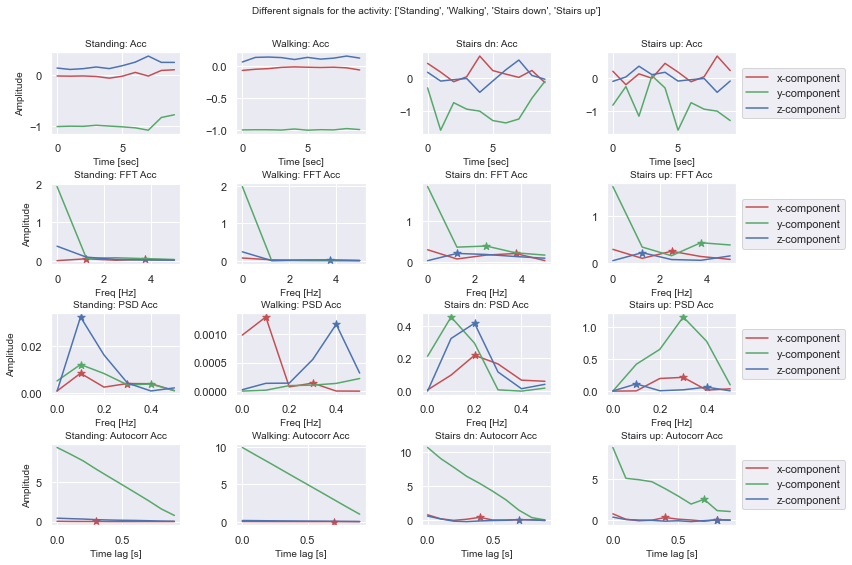

In [14]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Standing: Acc', 'Walking: Acc', 'Stairs dn: Acc', 'Stairs up: Acc'],
            ['Standing: FFT Acc', 'Walking: FFT Acc', 'Stairs dn: FFT Acc', 'Stairs up: FFT Acc'],
            ['Standing: PSD Acc', 'Walking: PSD Acc', 'Stairs dn: PSD Acc', 'Stairs up: PSD Acc'],
            ['Standing: Autocorr Acc', 'Walking: Autocorr Acc', 'Stairs dn: Autocorr Acc', 'Stairs up: Autocorr Acc']
           ]

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]
signal_no_list = [5, 20, 160, 120]
activity_name = list(activities_description.values())

f, axarr = plt.subplots(nrows=4, ncols=4, figsize=(12,8))
f.suptitle(suptitle.format(activity_name), fontsize=10)
 
for row_no in range(0,4):
    for col_no in range(0,4):
        for comp_no in range(0,3):
            color = colors[comp_no % 3]
            label = labels[comp_no % 3]

            axtitle  = axtitles[row_no][col_no]
            xlabel = xlabels[row_no]
            value_retriever = list_functions[row_no]

            ax = axarr[row_no][col_no]
            ax.set_title(axtitle, fontsize=10)
            ax.set_xlabel(xlabel, fontsize=10)
            
            if col_no == 0:
                ax.set_ylabel(ylabel, fontsize=10)

            signal_no = signal_no_list[col_no]
            signals = train_signals[signal_no, :, :]
            signal_component = signals[:, comp_no]
            x_values, y_values = value_retriever(signal_component, T, N, f_s)
            ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
            
            if row_no > 0:
                max_peak_height = 0.1 * np.nanmax(y_values)
                indices_peaks = detect_peaks(y_values, mph=max_peak_height)
                ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
            if col_no == 3:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

### Feature extraction 

In [15]:
X_train_ft, Y_train_ft = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)

print(X_train_ft.shape)
print(Y_train_ft.shape)

C:\Users\Vanessa\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 10, using nperseg = 10
  .format(nperseg, input_length))


(375, 120)
(375,)


### Resampling for Class Imbalance

In [16]:
print('Original dataset shape %s' % Counter(Y_train_ft))

ada = ADASYN()
X_res, y_res = ada.fit_resample(X_train_ft, Y_train_ft)

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2: 213, 3: 88, 4: 47, 1: 27})
Resampled dataset shape Counter({3: 231, 2: 213, 1: 212, 4: 209})


### 3) Classification with (traditional) Scikit-learn classifiers

In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X_res, y_res, train_size=0.8, random_state=1)

#### We will build several classifiers to see which one performs best to proceed with hyperparameter tuning.


In [18]:
models = batch_classify(X_train, Y_train, X_val, Y_val)
display_dict_models(models)

trained Gradient Boosting Classifier in 2.91 s
trained Random Forest in 0.34 s
trained Logistic Regression in 0.15 s
trained Nearest Neighbors in 0.00 s
trained Decision Tree in 0.02 s


C:\Users\Vanessa\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,classifier,train_score,test_score,train_time
0,Gradient Boosting Classifier,1.000000,0.942197,2.911525
1,Random Forest,1.000000,0.924855,0.343152
3,Nearest Neighbors,0.875723,0.843931,0.001200
4,Decision Tree,1.000000,0.843931,0.021316
2,Logistic Regression,0.800578,0.803468,0.154920


### Hyperparameter Tuning for Best Classifier

Gradient Boosting Classifier was the best classifier but the train time was much higher than the rest, for which we'll proceed with hyperparameter tuning for the 2nd best classifier: Random Forest.

In [19]:
# Create a based model
rf = RandomForestClassifier()

In [20]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Hyperparameters considered for tuning:

In [21]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [22]:
# Fit the grid search to the data
grid_result= grid_search.fit(X_train, Y_train)
                

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [24]:
grid_result.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [25]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [26]:
best_grid = grid_result.best_estimator_

In [27]:
grid_accuracy = evaluate(best_grid, X_val, Y_val)

Model Performance
Average Error: 0.1618 degrees.
Accuracy = 93.74%.


### Pickle the model file

In [28]:
pickl = {'model': best_grid}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

In [34]:
file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [47]:
model.predict(X_val[0,:].reshape(1,-1))[0]

3

In [49]:
list(X_val[0,:])

[0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3613156100044691,
 0.0,
 0.0,
 0.0,
 0.0,
 3.75,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3212469283765894,
 0.0,
 0.0,
 0.0,
 0.0,
 0.30000000000000004,
 0.7000000000000001,
 0.0,
 0.0,
 0.0,
 0.417852996473041,
 0.1729176091844369,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3537463661127467,
 0.0,
 0.0,
 0.0,
 0.0,
 2.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4276762969343201,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25948920032197165,
 0.0,
 0.0,
 0.0,
 0.0,
 1.25,
 3.75,
 0.0,
 0.0,
 0.0,
 0.24015726094839326,
 0.24918844009399227,
 0.0,
 0.0,
 0.0,
 0.30000000000000004,
 0.7000000000000001,
 0.0,
 0.0,
 0.0,
 -0.0839777718231256,
 0.252379834681453,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]